# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

In [5]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

### Dataset

In [6]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Found cached dataset imdb (/home/ethan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached split indices for dataset at /home/ethan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-5f37fd0866e4f89f.arrow and /home/ethan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-dd5732a0e6ac784c.arrow


((20000, 2), (5000, 2), (25000, 2))

### Vocabulary

In [7]:
def preprocess(base_text):
    """
    Preprocess the text before classification
    Args:
        base_text: the string to preprocess
    Return:
        The preprocessed text
    """
    return base_text.replace("<br />",' ')

def create_vocab(texts, frequencies = {}):
    for text in texts:
        for word in preprocess(text).split(" "):
            if word not in frequencies:
                frequencies[word] = 1
                continue
            frequencies[word] += 1
    return dict(sorted(frequencies.items(), key=lambda x: x[1], reverse=True))
frequencies = create_vocab(train_df["text"])

In [8]:
tokenizer = get_tokenizer("basic_english", language="en")
vocabulary = vocab(frequencies, min_freq = 100, specials=["<unk>", "<pad>"])
vocabulary.set_default_index(0)

### Vectorize

In [9]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    tokens = tokenizer(preprocess(text))
    tokens_ids = vocabulary.lookup_indices(tokens)
    return torch.tensor(tokens_ids, dtype=torch.long)

In [10]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)

In [11]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

### Batch generator

In [12]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    n_batches = len(X) // batch_size
    for i in range(n_batches):
        batch_X = X[i * batch_size : (i + 1) * batch_size]
        batch_y = y[i * batch_size : (i + 1) * batch_size]
        batch_X = nn.utils.rnn.pad_sequence(batch_X, padding_value=pad_id)
        yield batch_X, torch.tensor(batch_y, dtype=torch.long)

In [13]:
pad_token = "<pad>"
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [14]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [16]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    best_model = model
    best_loss = np.inf
    training_losses = []
    validation_losses = []

    for _ in tqdm(range(n_epochs), desc="Epochs"):
        # Training
        train_loss = 0
        n_batches = 0
        for X, y in train_gen():
            n_batches += 1
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X.transpose(1, 0)).squeeze()
            loss = criterion(y_pred, y.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= n_batches
        training_losses.append(train_loss)

        # Validation
        valid_loss = 0
        n_batches = 0
        for X, y in valid_gen():
            n_batches += 1
            X, y = X.to(device), y.to(device)
            y_pred = model(X.transpose(1, 0)).squeeze()
            loss = criterion(y_pred, y.float())
            valid_loss += loss.item()
        valid_loss /= n_batches
        validation_losses.append(valid_loss)

        # Save the best model.
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model = model

    return best_model, training_losses, validation_losses

In [17]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [18]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

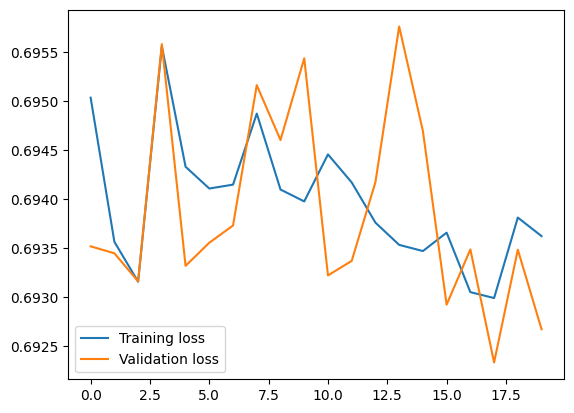

In [19]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

 ### Accuracy function

 Wee need to compute accuracy over a batch of data to not get an CUDA Erro out of memory.

In [27]:
def compute_accurracy(X, y, model):
    for X_batch, y_batch in data_generator(X, y, vocabulary[pad_token]):
        X = X_batch.to(device)
        y = y_batch.numpy()
        break
    with torch.no_grad():
        y_pred = model(X.transpose(0, 1)).squeeze()
        y_pred = y_pred.cpu().detach().numpy()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        valid = np.zeros(y.shape[0])
        valid[y_pred == y] = 1
        return valid.sum() / valid.shape[0]

In [21]:
accuracy_train = compute_accurracy(X_train, y_train, best_model)
accuracy_valid = compute_accurracy(X_valid, y_valid, best_model)
accuracy_test = compute_accurracy(X_test, y_test, best_model)
print(f"Training accuracy: {accuracy_train}")
print(f"Validation accuracy: {accuracy_valid}")
print(f"Test accuracy: {accuracy_test}")

Training accuracy: 0.625
Validation accuracy: 0.46875
Test accuracy: 0.59375


Result:
* Training accuracy: 0.625
* Validation accuracy: 0.46875
* Test accuracy: 0.59375

### LSTM

In [22]:
# LSTM class which uses an LSTM with PyTorch.
class LSTM(nn.Module):
     
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)
        
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X = X.transpose(1, 0)
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out.squeeze()

In [23]:
model_LSTM = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_LSTM.parameters())

In [24]:
best_model_LSTM, train_losses, valid_losses = train(model_LSTM, criterion, optimizer, 20, train_gen, valid_gen)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

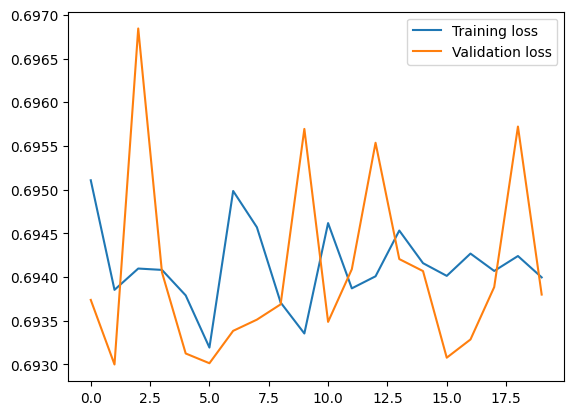

In [25]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

In [28]:
accuracy_train = compute_accurracy(X_train, y_train, best_model_LSTM)
accuracy_valid = compute_accurracy(X_valid, y_valid, best_model_LSTM)
accuracy_test = compute_accurracy(X_test, y_test, best_model_LSTM)
print(f"LSTM Training accuracy: {accuracy_train}")
print(f"LSTM Validation accuracy: {accuracy_valid}")
print(f"LSTM Test accuracy: {accuracy_test}")

LSTM Training accuracy: 0.5625
LSTM Validation accuracy: 0.5
LSTM Test accuracy: 0.46875


Results:
* LSTM Training accuracy: 0.5625
* Validation accuracy: 0.5
* Test accuracy: 0.46875

The results seems to be on par with the RNN implementation.

### Prediction function

In [52]:
def predict(text: str) -> Tuple[int, float]:
   X = text_pipeline(text)
   X = torch.tensor(X).to(device)
   y = best_model_LSTM(X.unsqueeze(0))
   classe = 1 if y >= 0.5 else 0
   confidence = y.item() if classe == 1 else 1 - y.item()
   return classe, confidence

In [53]:
predict("This movie is great")

/tmp/ipykernel_5349/3891559060.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to(device)


(0, 0.6720074415206909)

Result:
* 0, 0.6720074415206909